In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Here we simply predict the next step in the sequence. Each model is trained on 1/4 of the data

In [51]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [52]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [53]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [54]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [55]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [56]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [57]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device='cuda')  # (batch, output_dim)


In [58]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[:, -1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cuda")  # Use "cuda" if you have a GPU

# model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model2 = model2.to("cuda")  # Use "cuda" if you have a GPU

# model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
# model3 = model3.to("cuda")  # Use "cuda" if you have a GPU

criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)
# # scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.8)

# criterion2 = nn.SmoothL1Loss()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)
# criterion3 = nn.SmoothL1Loss()
# optimizer3 = optim.Adam(model3.parameters(), lr=0.0001)

In [59]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion1(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.4386138916015625, Val Loss: 1.3394750356674194
Epoch 10, Train Loss: 0.4283854067325592, Val Loss: 1.270699143409729
Epoch 20, Train Loss: 0.40716639161109924, Val Loss: 1.1631990671157837
Epoch 30, Train Loss: 0.34356725215911865, Val Loss: 0.8637323379516602
Epoch 40, Train Loss: 0.18391676247119904, Val Loss: 0.02715330198407173
Epoch 50, Train Loss: 0.17134888470172882, Val Loss: 0.0378311350941658
Epoch 60, Train Loss: 0.15203261375427246, Val Loss: 0.01932913064956665
Epoch 70, Train Loss: 0.14412683248519897, Val Loss: 0.014375734142959118
Epoch 80, Train Loss: 0.13587850332260132, Val Loss: 0.03193205967545509
Epoch 90, Train Loss: 0.1264108121395111, Val Loss: 0.010160922072827816
Epoch 100, Train Loss: 0.11626844853162766, Val Loss: 0.015423301607370377
Epoch 110, Train Loss: 0.10433012992143631, Val Loss: 0.019343096762895584
Epoch 120, Train Loss: 0.08986885100603104, Val Loss: 0.018206965178251266
Epoch 130, Train Loss: 0.07167572528123856, Val Loss:

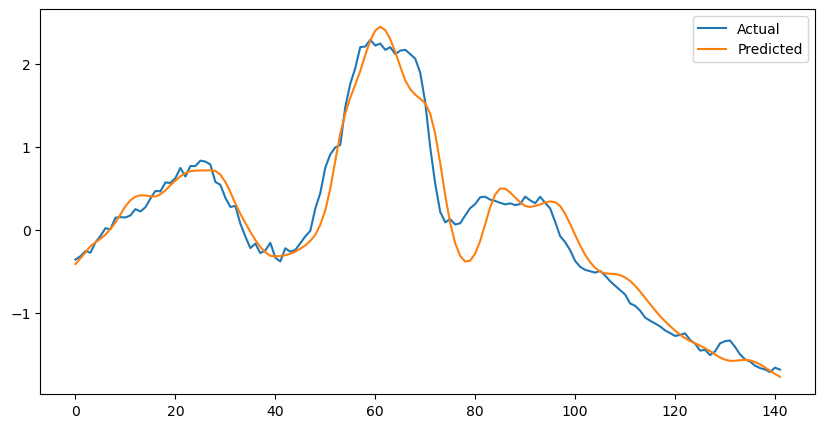

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label="Actual")
plt.plot(y_pred.cpu().detach().numpy(),label="Predicted")
plt.legend()
plt.show()

## Now let's test on datasets 2, 3, 4

### First create test set 2

In [61]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device='cuda')
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device='cuda')

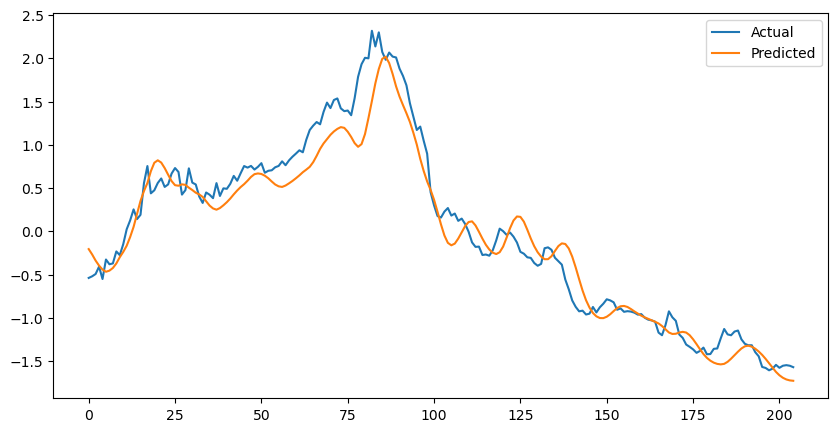

In [62]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [63]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')

MARE: 0.9171115756034851


### Now dataset 3

In [64]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

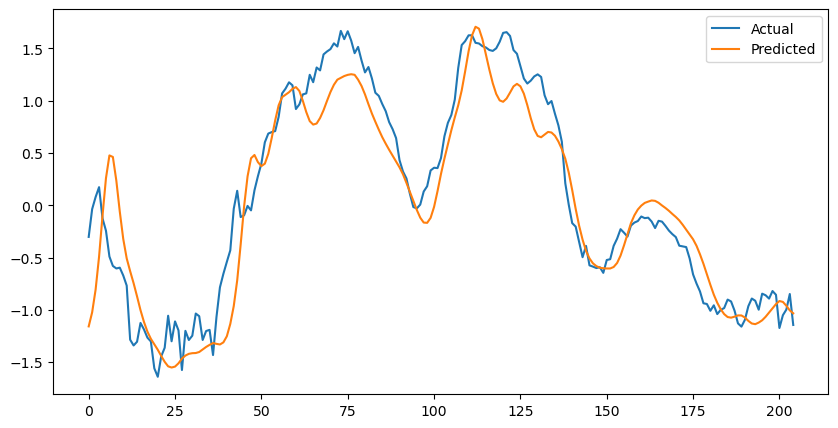

In [65]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [66]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')

MARE: 1.461972713470459


### Finally Dataset 4

In [67]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

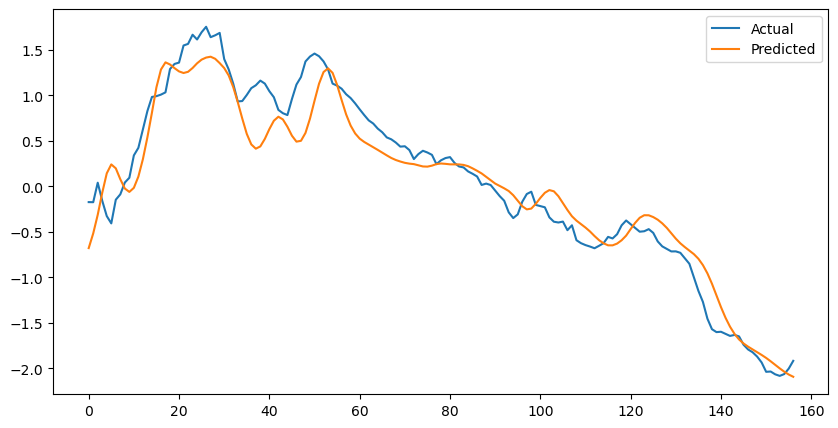

In [68]:
model1.eval()
with torch.no_grad():
    y_pred = model1(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [69]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')

MARE: 0.5443044304847717


## Now we train Model 2 on Dataset 2

In [70]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2).to(device='cuda')  # (batch, output_dim)

In [71]:
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cuda")  # Use "cuda" if you have a GPU
criterion2 = nn.SmoothL1Loss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.0001)

In [72]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion2(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.4490586221218109, Val Loss: 1.5404305458068848
Epoch 10, Train Loss: 0.4376911222934723, Val Loss: 1.508056879043579
Epoch 20, Train Loss: 0.4132881462574005, Val Loss: 1.4230380058288574
Epoch 30, Train Loss: 0.3385944664478302, Val Loss: 1.1423397064208984
Epoch 40, Train Loss: 0.13752512633800507, Val Loss: 0.252854585647583
Epoch 50, Train Loss: 0.12028767913579941, Val Loss: 0.020177865400910378
Epoch 60, Train Loss: 0.10427813977003098, Val Loss: 0.054379675537347794
Epoch 70, Train Loss: 0.09499508887529373, Val Loss: 0.02348840981721878
Epoch 80, Train Loss: 0.09246252477169037, Val Loss: 0.028398294001817703
Epoch 90, Train Loss: 0.08935203403234482, Val Loss: 0.05515192449092865
Epoch 100, Train Loss: 0.08575379103422165, Val Loss: 0.033690981566905975
Epoch 110, Train Loss: 0.0820906013250351, Val Loss: 0.034331291913986206
Epoch 120, Train Loss: 0.07801942527294159, Val Loss: 0.03343567997217178
Epoch 130, Train Loss: 0.0732656791806221, Val Loss: 0.0

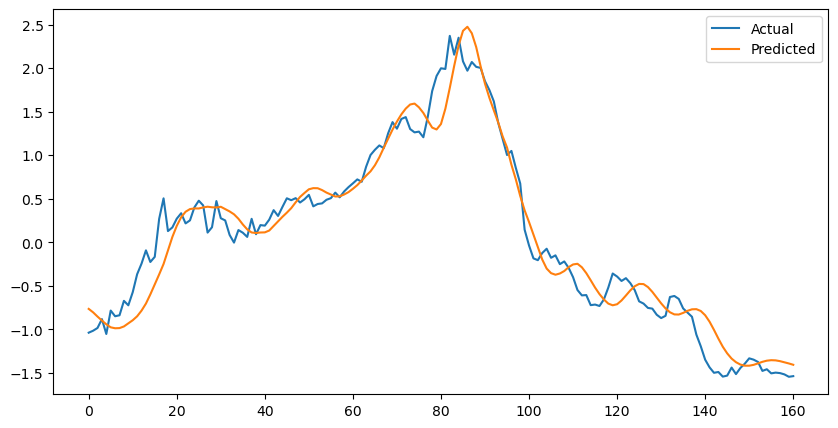

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor2.cpu().numpy(), label="Actual")
plt.plot(y_pred.cpu().detach().numpy(),label="Predicted")
plt.legend()
plt.show()

### Test on dataset 1

In [74]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device='cuda')
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device='cuda')

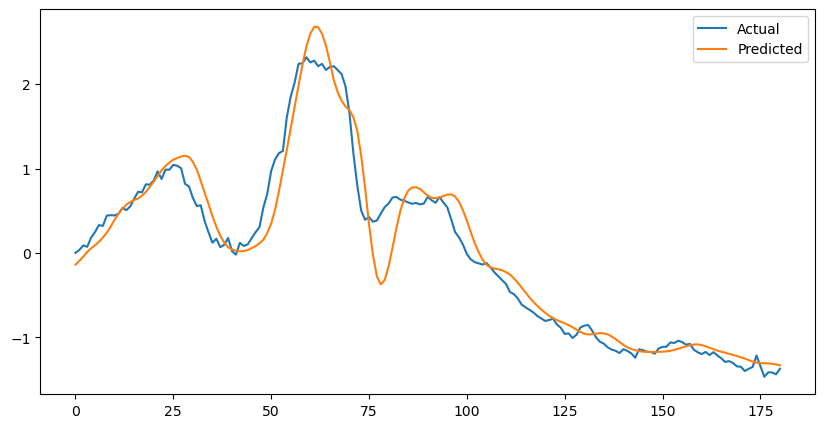

In [75]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_1)

plt.figure(figsize=(10,5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [76]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')

MARE: 1.8700319528579712


### Dataset 3

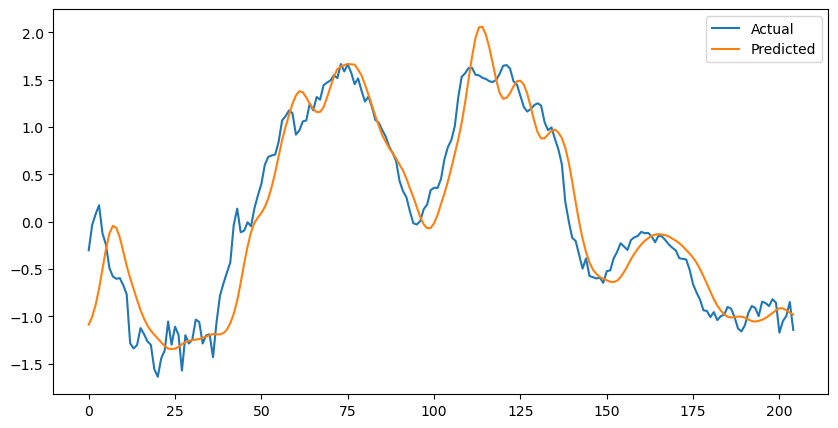

In [77]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [78]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')

MARE: 1.7399911880493164


### Dataset 4

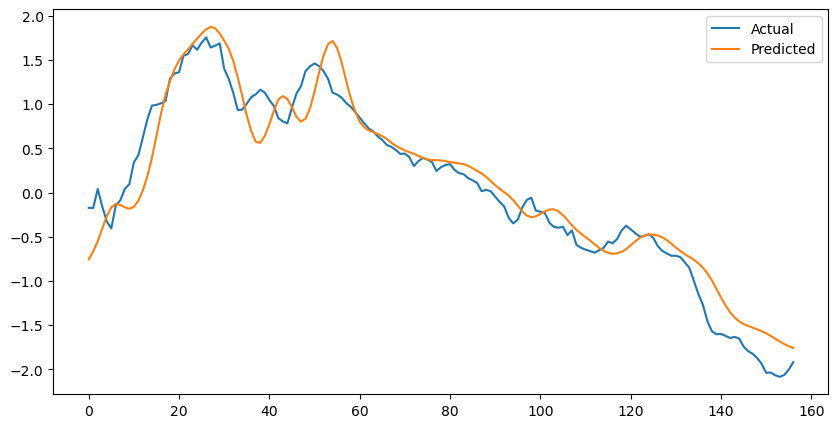

In [79]:
model2.eval()
with torch.no_grad():
    y_pred = model2(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [80]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')

MARE: 0.664006233215332


### Now train Model 3 on dataset 3

In [81]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3).to(device='cuda')  # (batch, output_dim)

In [82]:
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to(device='cuda')
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4)
criterion3 = nn.SmoothL1Loss()

In [83]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model3.train()

    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)

    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.4451216459274292, Val Loss: 0.5290826559066772
Epoch 10, Train Loss: 0.4272827208042145, Val Loss: 0.5875732898712158
Epoch 20, Train Loss: 0.4009832739830017, Val Loss: 0.6458466649055481
Epoch 30, Train Loss: 0.34078249335289, Val Loss: 0.6902862787246704
Epoch 40, Train Loss: 0.240114226937294, Val Loss: 0.5038914680480957
Epoch 50, Train Loss: 0.1521819829940796, Val Loss: 0.1485927850008011
Epoch 60, Train Loss: 0.14343951642513275, Val Loss: 0.027165740728378296
Epoch 70, Train Loss: 0.12357144802808762, Val Loss: 0.08158759772777557
Epoch 80, Train Loss: 0.11419500410556793, Val Loss: 0.08325739204883575
Epoch 90, Train Loss: 0.10507956892251968, Val Loss: 0.05517309159040451
Epoch 100, Train Loss: 0.09568941593170166, Val Loss: 0.06687149405479431
Epoch 110, Train Loss: 0.08505427837371826, Val Loss: 0.05363253876566887
Epoch 120, Train Loss: 0.072300985455513, Val Loss: 0.04840995743870735
Epoch 130, Train Loss: 0.05661061778664589, Val Loss: 0.041524060

### Test on dataset 1

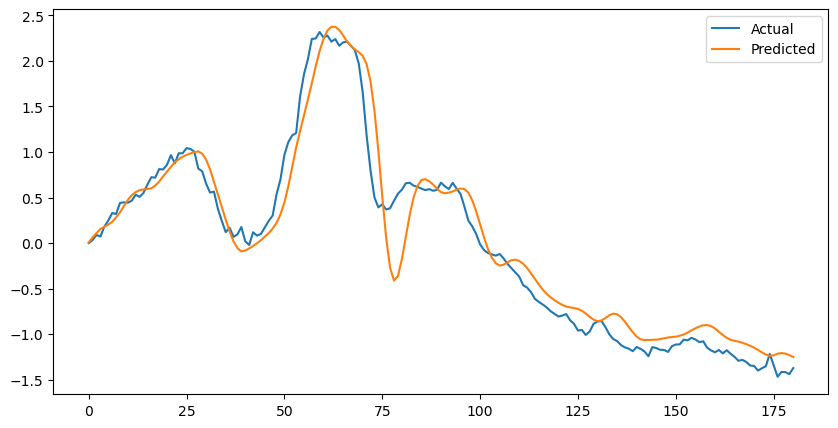

In [84]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_1)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [85]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')

MARE: 0.5399693846702576


### Test on dataset 2

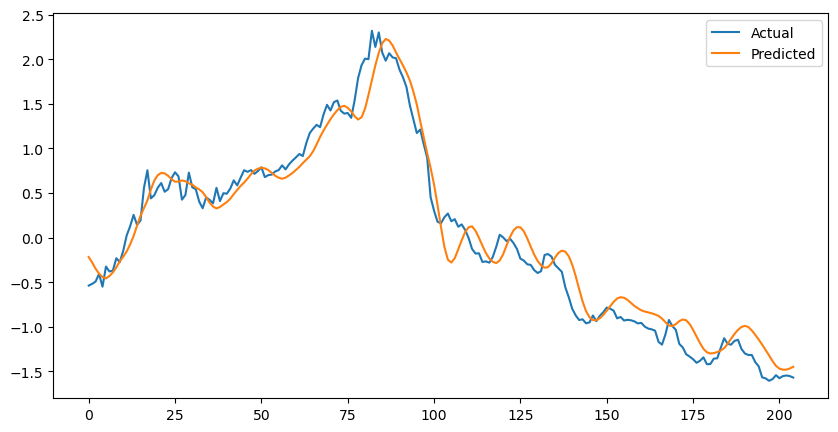

In [86]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [87]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')

MARE: 0.9190523624420166


### Test on dataset 4

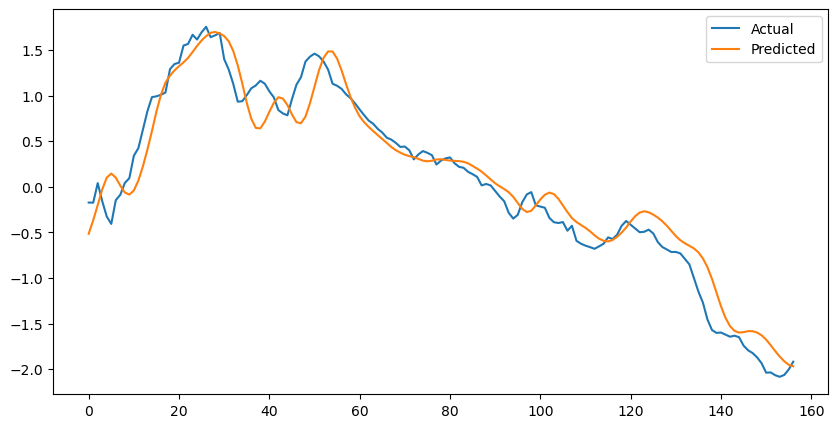

In [88]:
model3.eval()
with torch.no_grad():
    y_pred = model3(test_tensor_seq_4)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [89]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_4)}')

MARE: 0.5097588300704956


## Train model 4 on dataset 4

In [90]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4).to(device='cuda')  # (batch, output_dim)

In [91]:
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion4 = nn.SmoothL1Loss()
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
model4.to(device='cuda')

LSTMModel(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [92]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model4.train()
    optimizer4.zero_grad()
    y_pred = model4(train_seq_tensor4)

    loss = criterion4(y_pred, train_label_tensor4)
    train_losses.append(loss.item())
    loss.backward()
    optimizer4.step()

    # Validation
    model4.eval()
    with torch.no_grad():
        y_val = model4(val_seq_tensor4)
    val_loss = criterion4(y_val, val_label_tensor4)
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.4148458242416382, Val Loss: 2.2471845149993896
Epoch 10, Train Loss: 0.40061575174331665, Val Loss: 2.268059253692627
Epoch 20, Train Loss: 0.3759443163871765, Val Loss: 2.248505115509033
Epoch 30, Train Loss: 0.308679461479187, Val Loss: 2.090367317199707
Epoch 40, Train Loss: 0.18627159297466278, Val Loss: 1.6062400341033936
Epoch 50, Train Loss: 0.13074973225593567, Val Loss: 0.9882087111473083
Epoch 60, Train Loss: 0.12391803413629532, Val Loss: 0.8318818807601929
Epoch 70, Train Loss: 0.11381050944328308, Val Loss: 0.9419662356376648
Epoch 80, Train Loss: 0.10694889724254608, Val Loss: 0.6813642382621765
Epoch 90, Train Loss: 0.10177096724510193, Val Loss: 0.582299530506134
Epoch 100, Train Loss: 0.09561615437269211, Val Loss: 0.6397705078125
Epoch 110, Train Loss: 0.08889762312173843, Val Loss: 0.5989559888839722
Epoch 120, Train Loss: 0.08140458166599274, Val Loss: 0.5813647508621216
Epoch 130, Train Loss: 0.07279683649539948, Val Loss: 0.5545392036437988


### Test on dataset 1

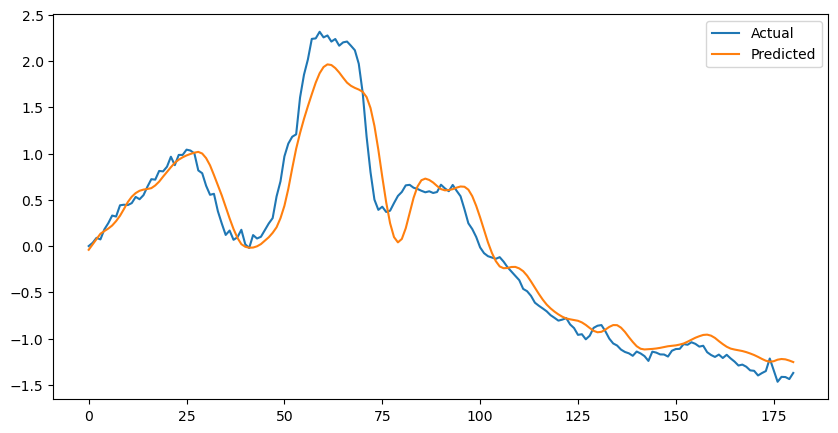

In [93]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_1)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [94]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_1)}')

MARE: 0.8357445001602173


### Test on dataset 2

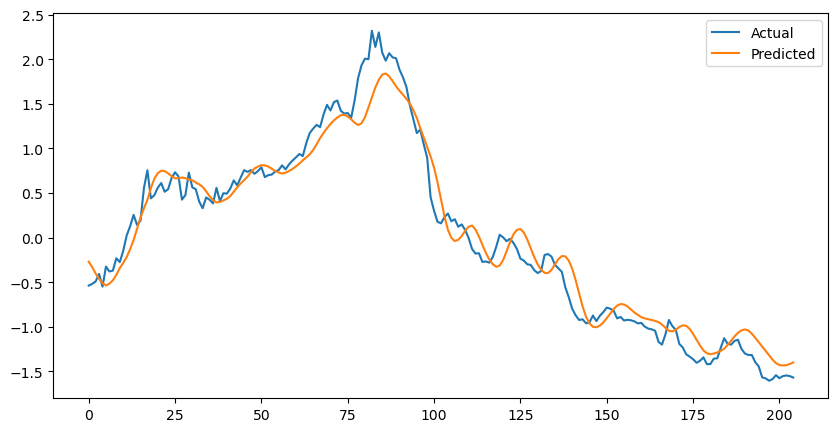

In [95]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_2)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [96]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_2)}')

MARE: 1.0741443634033203


### Test on dataset 3

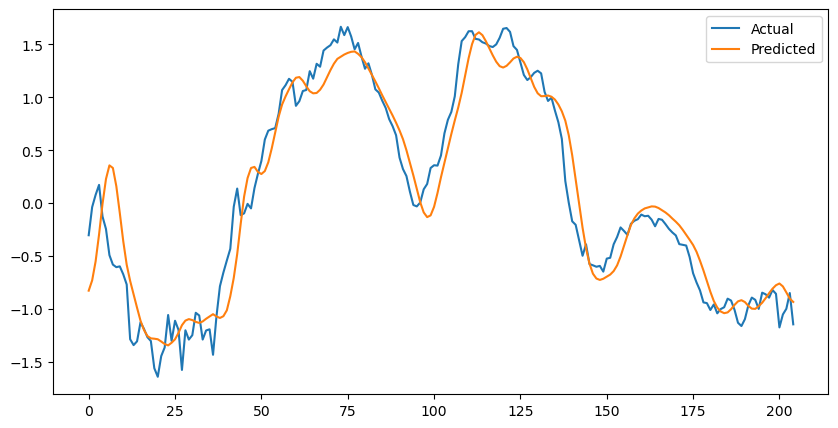

In [97]:
model4.eval()
with torch.no_grad():
    y_pred = model4(test_tensor_seq_3)

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()

In [98]:
print(f'MARE: {MARE(y_pred, test_tensor_labels_3)}')

MARE: 1.5726563930511475
